# Geospatial data analysis of time series
Quinn Brencher

In [1]:
# Import required packages
%matplotlib inline
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import h5py
import xarray as xr
import datetime as dt
import rioxarray

## Load in and rebuild uncorrected time series data

In [2]:
os.chdir('/Users/qbren/Desktop/taco/projects/atmospheric_correction/data_processing/mintpy_nocorrection_sanjuans_asc')

In [3]:
# open time series data 
uncorrected_disp_fn = 'timeseries_ramp_demErr.h5'
uncorrected_disp_df = xr.open_dataset(uncorrected_disp_fn, phony_dims='sort')

In [4]:
# rename variables
uncorrected_disp_df = uncorrected_disp_df.rename({'date': 'dstring',
                          'timeseries': 'displacement'})

In [5]:
# rename dims
uncorrected_disp_df = uncorrected_disp_df.rename_dims({'phony_dim_0':'date',
                               'phony_dim_1':'latitude',
                               'phony_dim_2':'longitude'})

In [6]:
# use the 'date' data variable to create date list
date_list = []
for i in range(uncorrected_disp_df['dstring'].size):
    date = str(uncorrected_disp_df['dstring'][i].item())
    date_list.append(dt.datetime.strptime(date[2:10], '%Y%m%d'))

In [7]:
# function to rewrite coordinates from metadata
def coord_range(df, coord):
    if coord == 'lat' or coord == 'latitude':
        latrange = np.linspace(float(df.attrs['Y_FIRST']),((float(df.attrs['Y_STEP'])*float(df.attrs['LENGTH']))+float(df.attrs['Y_FIRST'])),int(df.attrs['LENGTH']))
        return latrange
    elif coord == 'lon' or coord == 'longitude':
        lonrange = np.linspace(float(df.attrs['X_FIRST']),((float(df.attrs['X_STEP'])*float(df.attrs['WIDTH']))+float(df.attrs['X_FIRST'])),int(df.attrs['WIDTH']))
        return lonrange

In [8]:
# rebuild coordinates
uncorrected_disp_df = uncorrected_disp_df.assign_coords({'date': ('date', np.array(date_list)),
                                 'latitude': ('latitude', coord_range(uncorrected_disp_df, 'lat')),
                                 'longitude': ('longitude', coord_range(uncorrected_disp_df, 'lon'))})

In [9]:
# set correct CRS
uncorrected_disp_df = uncorrected_disp_df.rio.write_crs(32613)
uncorrected_disp_df.rio.crs

CRS.from_epsg(32613)

## Load in uncorrected average velocity

In [10]:
# load in average velocity
uncorrected_vel_fn = 'velocity.h5'
uncorrected_vel_df = xr.open_dataset(uncorrected_vel_fn, phony_dims='sort')

In [11]:
# rebuild dataset
uncorrected_vel_df = uncorrected_vel_df.rename_dims({'phony_dim_0':'latitude',
                             'phony_dim_1':'longitude'})

uncorrected_vel_df = uncorrected_vel_df.assign_coords({'latitude': ('latitude', coord_range(uncorrected_vel_df, 'lat')), 
                               'longitude': ('longitude', coord_range(uncorrected_vel_df, 'lon'))})

uncorrected_vel_df = uncorrected_vel_df.rio.write_crs(32613)

## Load in corrected time series data

In [12]:
os.chdir('/Users/qbren/Desktop/taco/projects/atmospheric_correction/data_processing/mintpy_correction_sanjuans_asc')

In [13]:
# open time series data 
corrected_disp_fn = 'timeseries_ramp_demErr.h5'
corrected_disp_df = xr.open_dataset(corrected_disp_fn, phony_dims='sort')

# rename variables
corrected_disp_df = corrected_disp_df.rename({'date': 'dstring',
                          'timeseries': 'displacement'})

# rename dims
corrected_disp_df = corrected_disp_df.rename_dims({'phony_dim_0':'date',
                               'phony_dim_1':'latitude',
                               'phony_dim_2':'longitude'})

# rebuild coordinates
corrected_disp_df = corrected_disp_df.assign_coords({'date': ('date', np.array(date_list)),
                                 'latitude': ('latitude', coord_range(corrected_disp_df, 'lat')),
                                 'longitude': ('longitude', coord_range(corrected_disp_df, 'lon'))})

# set correct CRS
corrected_disp_df = corrected_disp_df.rio.write_crs(32613)
corrected_disp_df.rio.crs

CRS.from_epsg(32613)

## Load in corrected velocity

In [14]:
# load in average velocity
corrected_vel_fn = 'velocity.h5'
corrected_vel_df = xr.open_dataset(corrected_vel_fn, phony_dims='sort')

# rebuild dataset
corrected_vel_df = corrected_vel_df.rename_dims({'phony_dim_0':'latitude',
                             'phony_dim_1':'longitude'})

corrected_vel_df = corrected_vel_df.assign_coords({'latitude': ('latitude', coord_range(corrected_vel_df, 'lat')), 
                               'longitude': ('longitude', coord_range(corrected_vel_df, 'lon'))})

corrected_vel_df = corrected_vel_df.rio.write_crs(32613)

## Load in polygons

In [15]:
# load json of aoi 
aoi_fn = '/Users/qbren/Desktop/taco/projects/atmospheric_correction/data_processing/shapefiles/sanjuans_rg8_asc.shp'
aoi_gdf = gpd.read_file(aoi_fn)

In [16]:
# load json of stable reference areas
stable_fn = '/Users/qbren/Desktop/taco/projects/atmospheric_correction/data_processing/shapefiles/sanjuans_stable6_asc.shp'
stable_gdf = gpd.read_file(stable_fn)

## Change reference points

In [17]:
# function to find value of new reference point in each time slice and subtract it from data array

def change_ref(xarray, lat, lon):
    rref_list = []
    reref = xarray.copy(deep=True)
    for i in range(xarray.sizes['date']):
        # get value from grid
        rref_list.append(float(xarray.isel(date=i).displacement.sel(longitude=lon, latitude=lat, method="nearest").values))
    reref['displacement'] = xarray['displacement'] - xr.DataArray(rref_list, dims='date')
    return reref       

In [18]:
#Sanity check: reference point in highly degforming area
uncorrected_disp_rref = change_ref(uncorrected_disp_df, 4176891, 251524)
corrected_disp_rref = change_ref(corrected_disp_df, 4176891, 251524)

## Displacement of aoi in corrected and uncorrected

In [19]:
# clip to aoi, clip to reference areas
corrected_disp_aoi = corrected_disp_rref.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)
uncorrected_disp_aoi = uncorrected_disp_rref.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)

corrected_disp_stable = corrected_disp_rref.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs, drop=False)
uncorrected_disp_stable = uncorrected_disp_rref.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs, drop=False)

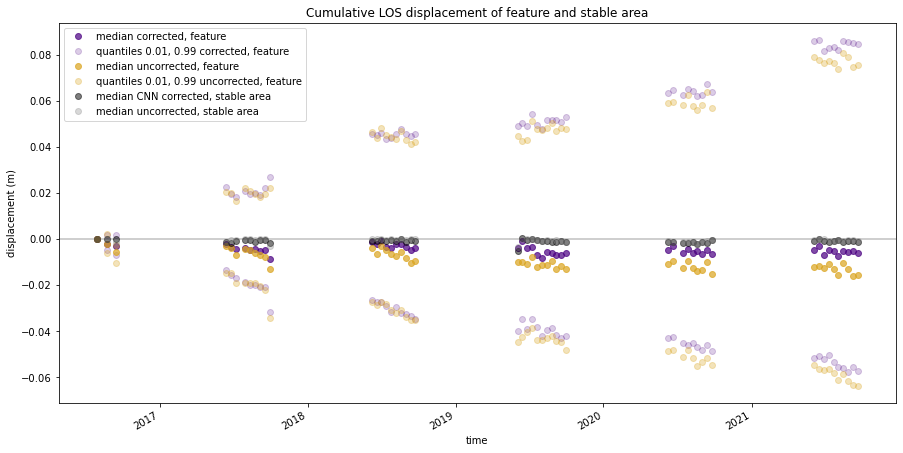

In [22]:
# look at cumulative displacement in aoi and reference area
quantile = [0.01, 0.99]

f, ax = plt.subplots(figsize=(15,7))
ax.axhline(y=0, c='gray', alpha=0.5)

corrected_disp_aoi.median(dim=('latitude', 'longitude')).displacement.plot(ax=ax, label='median corrected, feature', c='indigo', marker='o', linewidth=0, alpha=0.7)
corrected_disp_aoi.quantile(q=quantile[0], dim=('latitude', 'longitude')).displacement.plot(ax=ax, label=f'quantiles {quantile[0]}, {quantile[1]} corrected, feature', c='indigo', marker='o', linewidth=0, alpha=0.2)
corrected_disp_aoi.quantile(q=quantile[1], dim=('latitude', 'longitude')).displacement.plot(ax=ax, c='indigo', marker='o', linewidth=0, alpha=0.2)

uncorrected_disp_aoi.median(dim=('latitude', 'longitude')).displacement.plot(ax=ax, label='median uncorrected, feature', c='goldenrod', marker='o', linewidth=0, alpha=0.7)
uncorrected_disp_aoi.quantile(q=quantile[0], dim=('latitude', 'longitude')).displacement.plot(ax=ax, label=f'quantiles {quantile[0]}, {quantile[1]} uncorrected, feature', c='goldenrod', marker='o', linewidth=0, alpha=0.3)
uncorrected_disp_aoi.quantile(q=quantile[1], dim=('latitude', 'longitude')).displacement.plot(ax=ax, c='goldenrod', marker='o', linewidth=0, alpha=0.3)

corrected_disp_stable.median(dim=('latitude', 'longitude')).displacement.plot(ax=ax, label='median CNN corrected, stable area', c='k', marker='o', linewidth=0, alpha=0.5)
uncorrected_disp_stable.median(dim=('latitude', 'longitude')).displacement.plot(ax=ax, label='median uncorrected, stable area', c='gray', marker='o', linewidth=0, alpha=0.3)


ax.set_title('Cumulative LOS displacement of feature and stable area')
ax.set_ylabel('displacement (m)')
ax.set_xlabel('time')
ax.legend();

#plt.savefig('dispv0.png', dpi=300)

## Convert to tif for download

In [21]:
#uncorrected_vel_df.rio.to_raster('nocorrection_velocv1.tif')
#corrected_vel_df.rio.to_raster('correction_velocv1.tif')